<a href="https://colab.research.google.com/github/JunJul/NSDC-Project-Heart-Disease-Classification/blob/Master/Indicator_of_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**:

  The project is called the heart disease classification. In this project, I led three people to develop classification models to predict if a person has heart disease based on some simple indicators of heart disease such as BMI, Age, different walking speed, and so on in this dataset from a *CDC* heart disease survey in 2022. **Furthermore, I took respnsbility of EDA, pipeline, Models, and Data Preprocessing in the indicators of Heart Disease project**.

  The purpose of this project was to help people understand how to avoid heart disease based on some simple indicators. Also, people can examine what probability they are getting heart disease through a machine learning model, so people can have a good life-style to maintain health.
  
  We developed **XGBClassifier, LogisticRegression, DecisionTreeClassifier, and RandomForestClassifier** by sciKit-learn. According to the F1-score and validation score, we concluded that the RandomForestClassifier and the DecisionTreeClassifier outperformed than others. The RandomForestClassifier achieves 97% in F1-score and 96% in validation score. The DecisionTreeClassifier almost has the same result as the RandomForestClassifier.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## **Functions**

Author: Junze He

In [4]:
# split the features into numerical and categorical features
def split_types(data):
  numerical_features = data.select_dtypes(["int64", "float64"])
  categorical_features = data.select_dtypes(["object", "category"])

  return numerical_features, categorical_features

# Encoding Functions
  # encode the categorical features into ordinal numbers
def ordinal_catfeatures_encoder(data):
  encoder = OrdinalEncoder()
  encoded_data = encoder.fit_transform(data)
  encoded_dataframe =  pd.DataFrame(encoded_data)
  encoded_dataframe.columns = data.columns

  return encoded_dataframe

  # one-hot encoding
def onehot_eoncoder(data):
  encoder = OneHotEncoder()
  encoded_data = encoder.fit_transform(data)
  encoded_dataframe = pd.DataFrame(encoded_data.toarray())

  return encoded_dataframe

  # Frequency encoding
def frequency_encoder(data, is_normalize = True):
  length = data.shape[1]
  columns = data.columns

  for i in range(length):
    frequency = data[columns[i]].value_counts(normalize=True)
    data[columns[i]] = data[columns[i]].map(frequency)

  return data;

# statsmodels for logistic Regression
def statsLogModel(x, y):
  x = sm.add_constant(x)
  statsLogitModel = sm.Logit(y, x).fit()

  return statsLogitModel

# plot the confusion matrix
def confusionMatrixPlot(cm):
    # cm = model.pred_table(threshold=0.5)
    cm_dis = ConfusionMatrixDisplay(cm, display_labels=['No Heart Disease',
                                                        "Heart Disease Detected"])
    cm_dis.plot(cmap=plt.cm.Blues)

# scale data
def scale(x):
  scaler = StandardScaler()
  scaler.fit(x)
  scaled_x = scaler.transform(x)
  return scaled_x

Author: Giovanni Cinque

In [5]:
# oversampling
def oversampling(x, y):
  ros = RandomOverSampler()
  x, y = ros.fit_resample(x, y)
  return x, y

# undersampling
def undersampling(x,y):
  rus = RandomUnderSampler()
  x, y = ros.fit_resample(x,y)
  return x, y

## **EDA**

In [8]:
import os
from google.colab import files
import shutil

new_folder = "Data"

if os.path.isdir(new_folder):
  shutil.rmtree(new_folder)

os.mkdir(new_folder)

# Upload Files
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(new_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving heart_2020_cleaned.csv to heart_2020_cleaned.csv
move heart_2020_cleaned.csv to Data/heart_2020_cleaned.csv


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Author: Junze He

In [10]:
# data = pd.read_csv("/content/heart_2020_cleaned.csv")
data = pd.read_csv("/content/Data/heart_2020_cleaned.csv")

In [11]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


The predicted variable is HeartDisease which includes 292422 No as without heart disease and 27373 Yes as having heart disease

In [6]:
data.HeartDisease.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

Most the variables in the dataset are object type and only four variavles are numerical type.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

The dataset has 319795 observations.

In [8]:
data.shape

(319795, 18)

In [9]:
data.columns.tolist()

['HeartDisease',
 'BMI',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'PhysicalHealth',
 'MentalHealth',
 'DiffWalking',
 'Sex',
 'AgeCategory',
 'Race',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'SleepTime',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

These are the number of unique values in each variable.

In [10]:
data.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

The dataset is clean, so we don't have to clean data

In [11]:
data.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [13]:
data = data.dropna()

In [14]:
# split response and predicted variables

response_feature = data.HeartDisease
predicted_features = data.drop("HeartDisease", axis=1)

In [15]:
# split the nuermical and categorical variables from the predicted variables

numerical_data, categorical_data = split_types(predicted_features)

Since this is a binary classification, so we need to map Yes and No values in the HeartDisease variable to 1 and 0 respectively

In [16]:
# map Yes and No values to 1 and 0 respectively

response_feature = response_feature.map({"Yes": 1, "No": 0})
response_feature.head()

0    0
1    0
2    0
3    0
4    0
Name: HeartDisease, dtype: int64

The martix scatter plot shows the relationship between numerical variables in the predicted variables.

The MentalHealth, PhysicalHealth, and sleepTime have the same scale values ranging from 0 to 30, but rhe BMI does not have the same scale.

None of them has a significant correaltion, so the muticolleanrity issue does not happen at here

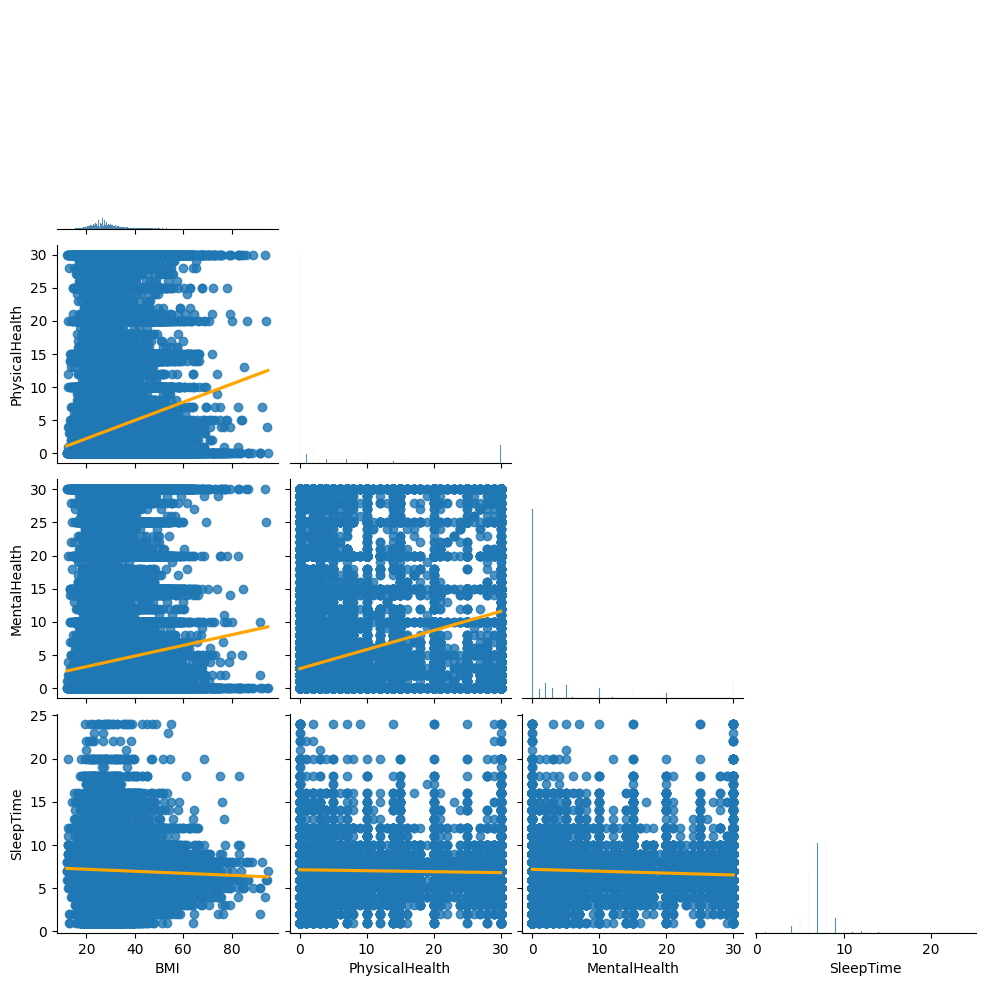

In [21]:
sns.pairplot(numerical_data, kind='reg',
             corner=True, plot_kws={'line_kws':{'color':'orange'}})

The count plot shows the number of observation between Yes and No is different. The No outcome is extremely greater than yes, so the outcomes in reponse variable is imbalance

<Axes: xlabel='HeartDisease', ylabel='count'>

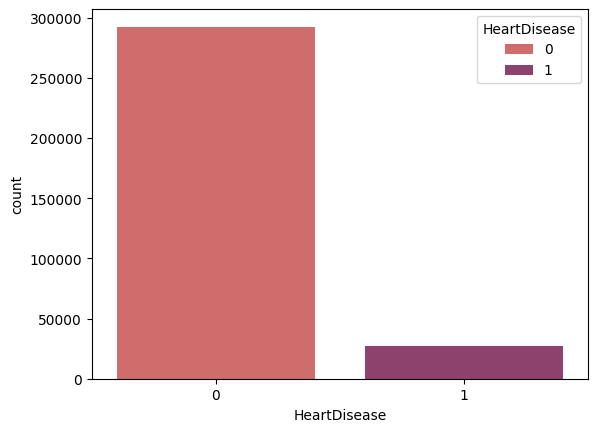

In [80]:
sns.countplot(x = response_feature,
              hue = response_feature, palette ="flare")

 The matrxiCountPlot function is to create a list of count plot in a matrix form that shows the number of uniqe observation in each categorical variable

In [69]:
# The function takes a dataframe arugument to generate a matrix count plot
def maxtrixCountPlot(input_data):
    rows = 4
    cols = 3
    row_count = col_count = 0
    fig, axe = plt.subplots(rows, cols, figsize=(20,15))

    for i in input_data.columns:
        sns.countplot(x = input_data[i],
                      ax=axe[row_count, col_count],
                      hue = input_data[i],
                      palette="flare")
        col_count += 1

        if col_count >= cols:
            col_count = 0
            row_count += 1

    fig.delaxes(axe[3, 1])
    fig.delaxes(axe[3, 2])

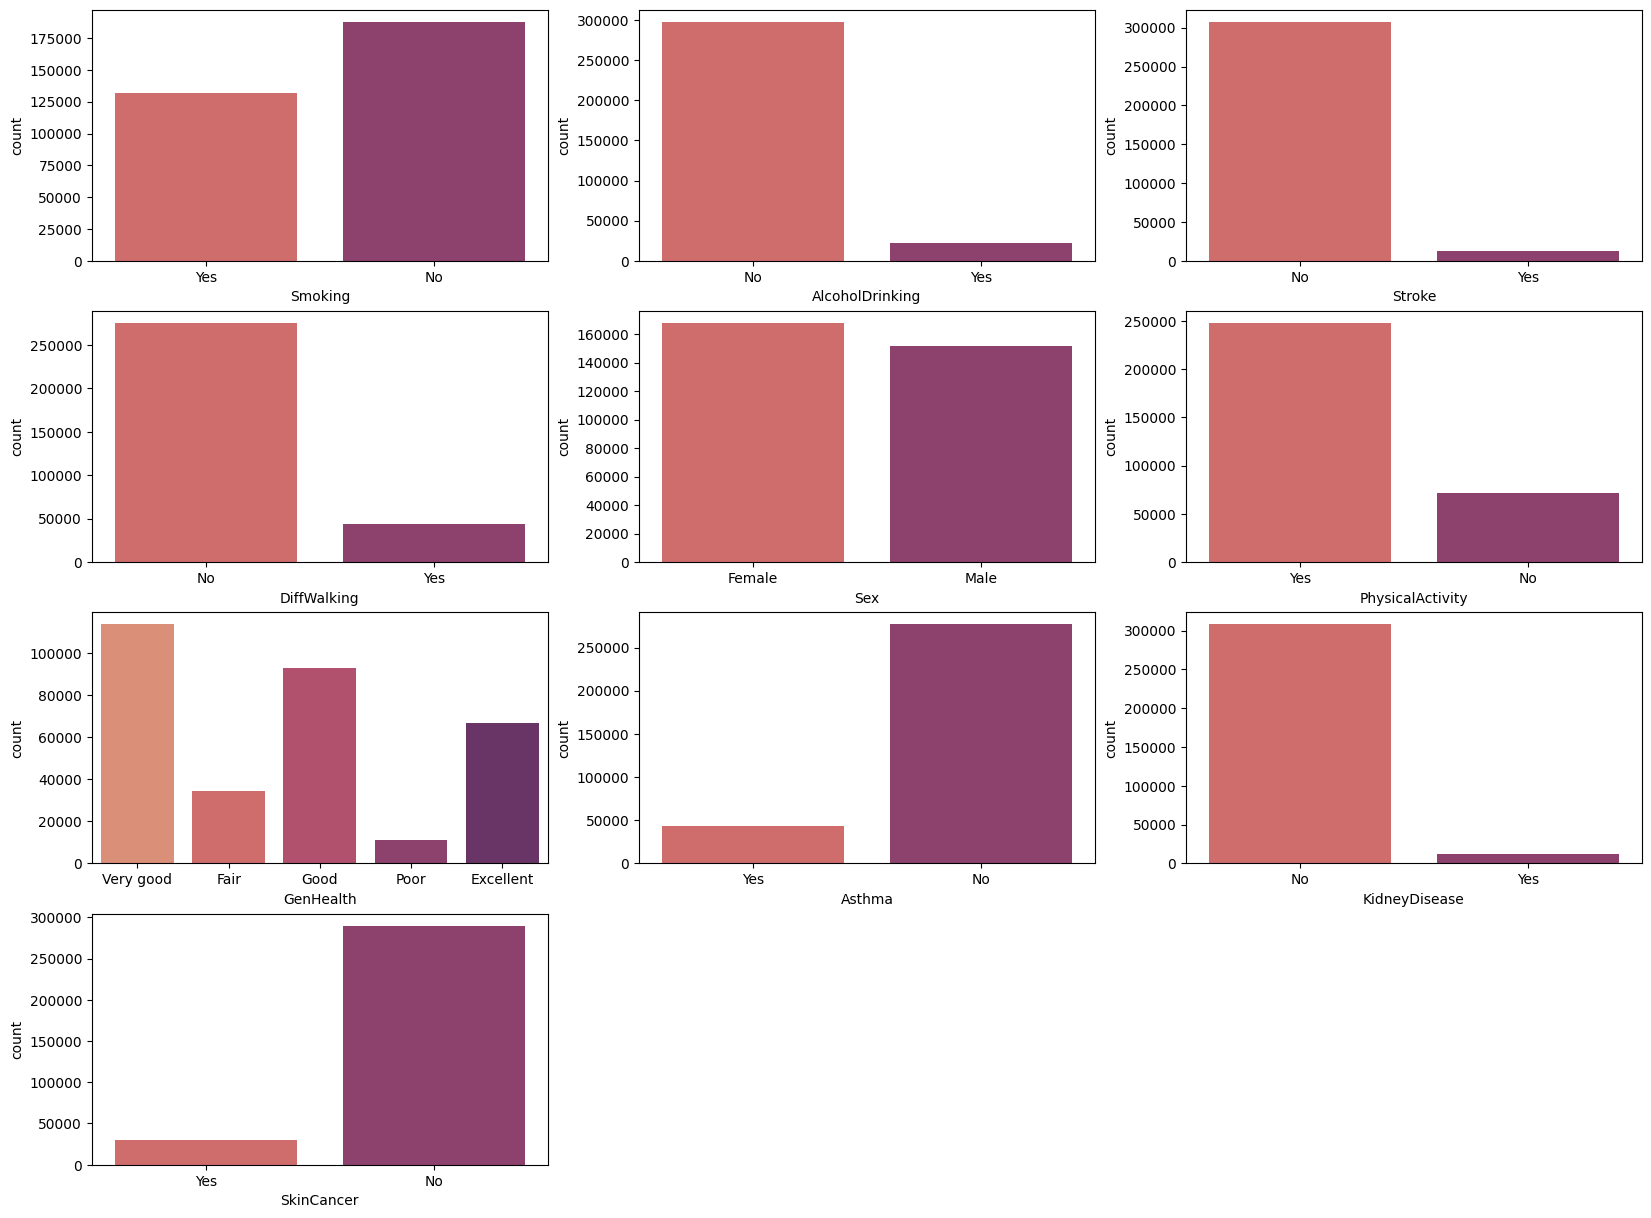

In [70]:
# sns.countplot(data = categorical_data, x= "Smoking", palette="flare")
maxtrixBoxPlot(categorical_data.drop(["Race", "Diabetic", "AgeCategory"], axis=1))

This is the countplot of Diabetic variable. From the variable, we know that there are two special cases which are No, borderline diabetes and Yes, during pregnancy in the Diabetic variable.

The No, borderline diabetes means they have a high blood surgar level than normal but not enough to be identified as diabetes

The Yes, during preganacy means a female is diabetic when she is pregnant.

<Axes: xlabel='count', ylabel='Diabetic'>

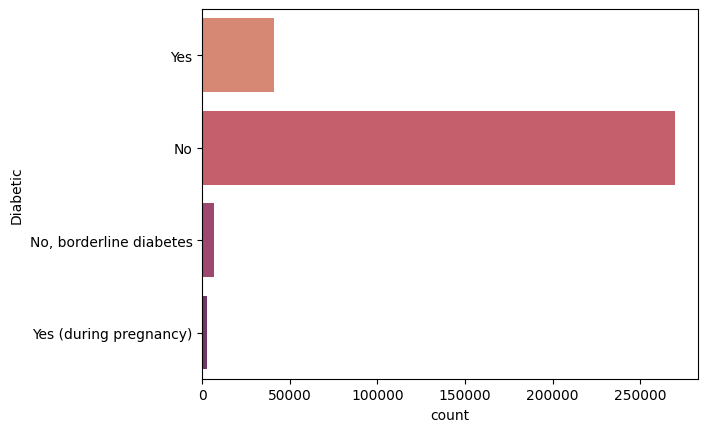

In [73]:
 sns.countplot(data = categorical_data,
               y = "Diabetic",
               hue = "Diabetic",
               palette="flare")

<Axes: xlabel='count', ylabel='AgeCategory'>

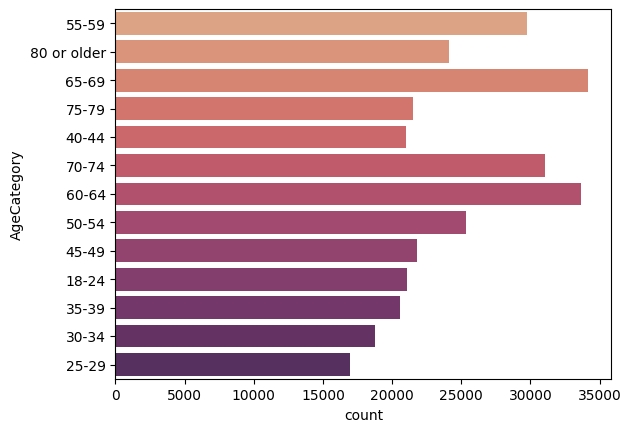

In [24]:
sns.countplot(data = categorical_data,
               y = "AgeCategory",
               hue = "AgeCategory",
               palette="flare")

In this dataset, the CDC has more white people as observations

<Axes: xlabel='count', ylabel='Race'>

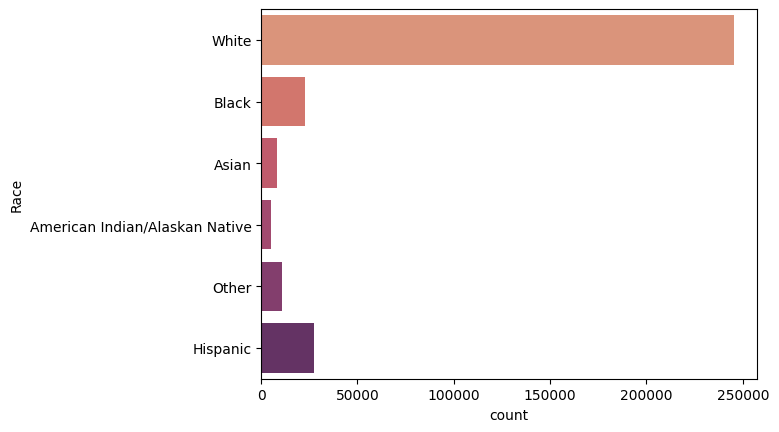

In [74]:
 sns.countplot(data = categorical_data,
               y = "Race",
               hue = "Race",
               palette="flare")

#### Multicollinearity

Checking multicollinearity to avoid a model ovefits data

This heatmap only consists of numerical varibable, and exactly matches what I mentioned above said they do not have a direct correlation.

<Axes: >

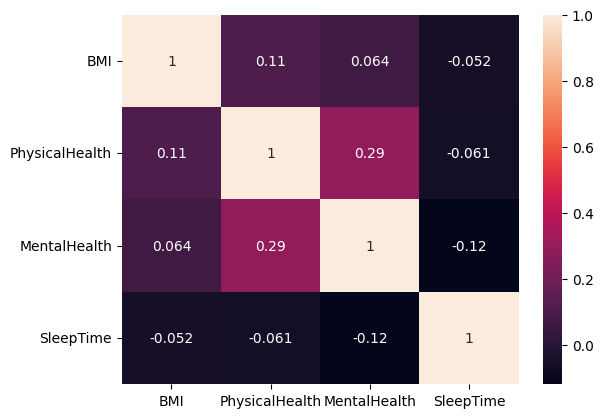

In [86]:
# calculate correlation between numerical variables
numerical_corrleation = numerical_data.corr()
sns.heatmap(numerical_corrleation, annot=True)

Encoded categorical variables by ordinal encoding and check multicollinearity among each categorical variable. None of them has a significant correlation, so multicollinearity does not exist in the categorical variables.

In [17]:
ordianlEncoded_categories = ordinal_catfeatures_encoder(categorical_data)

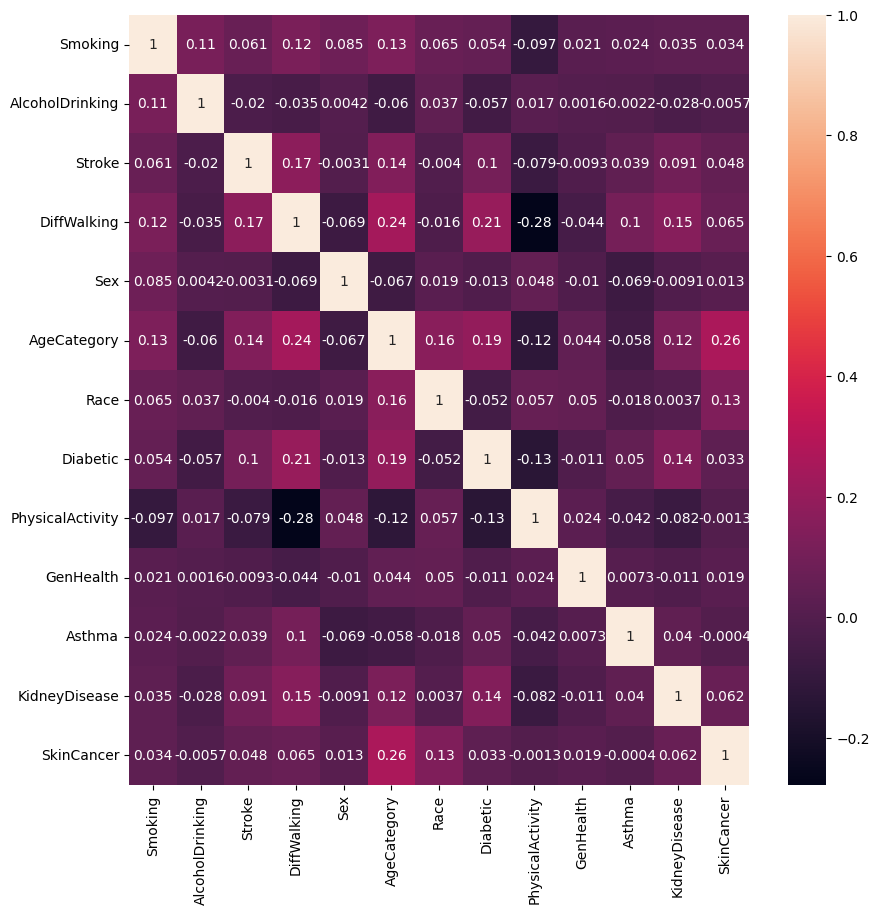

In [88]:
correlation_cate = ordianlEncoded_categories.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_cate, annot=True)
plt.show()

Concat numerical and encoded categorical variable and find correlation among them. There is no multicollinearity issue among all the variables in this dataset.

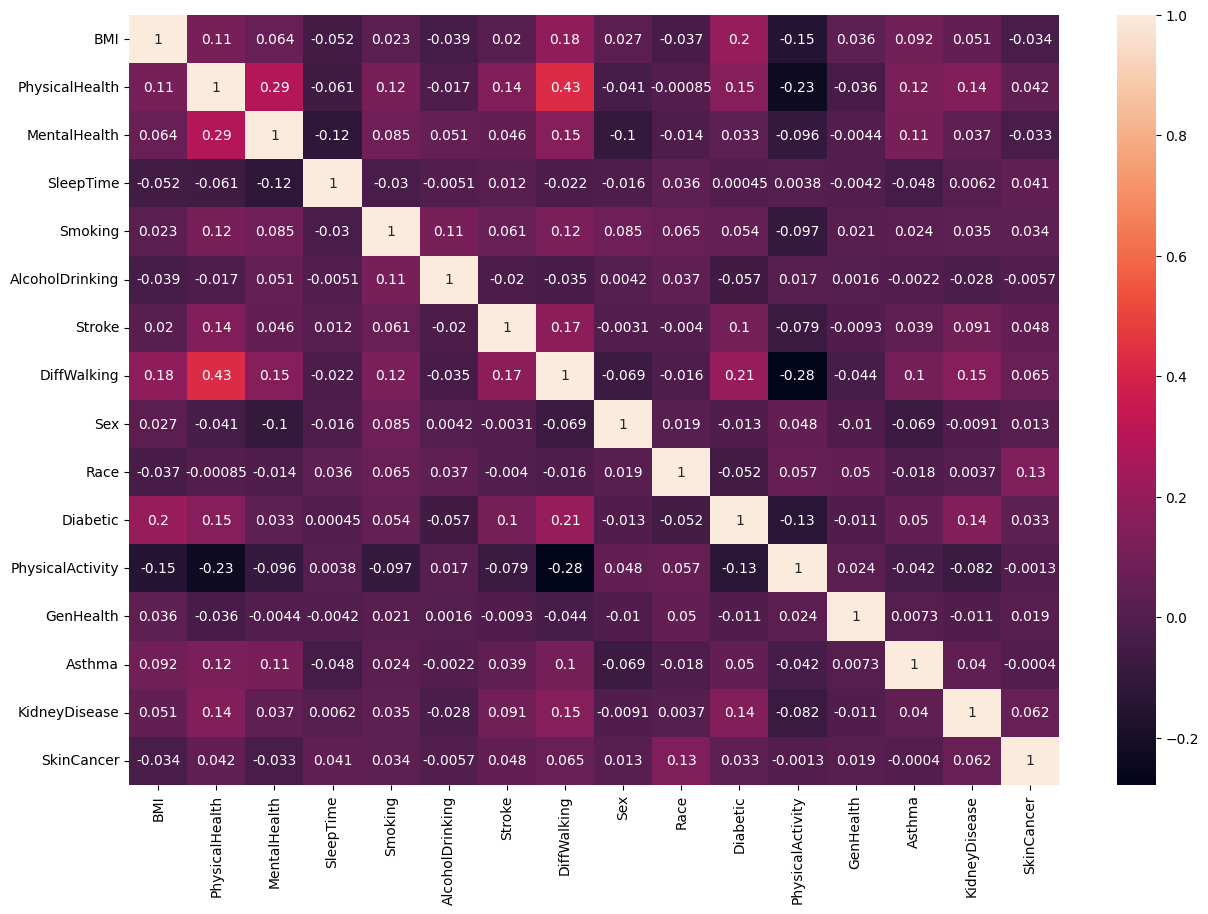

In [ ]:
correlation_numCate = pd.concat([numerical_data, ordianlEncoded_categories], axis = 1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_numCate, annot=True)
plt.show()

## StatsModels

The purpose of develop statsmodels is to uitilize descriptive statistics like checking signifincance of the overall model and predictors.

Also, investigate how different encoding technique produce different statistics results,

### StatsModel1

In [18]:
statsLogitModel1 = statsLogModel(ordianlEncoded_categories, response_feature)

Optimization terminated successfully.
         Current function value: 0.235142
         Iterations 8


In [19]:
ordianlEncoded_categories.isnull().sum()

Smoking             0
AlcoholDrinking     0
Stroke              0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

The statsmodel1 is developed only by categorical variables encoded by ordinal numbers. The p-value is 0 which demonstrates that the model with the predicted variables is significant.

All the predicted variables are significant based on their p-values, but AlcoholDrinking has a negative coefficient, so this result is unexpected.

In [20]:
statsLogitModel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319781
Method:                           MLE   Df Model:                           13
Date:                Thu, 28 Mar 2024   Pseudo R-squ.:                  0.1953
Time:                        04:40:43   Log-Likelihood:                -75197.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.5114      0.041   -133.054      0.000      -5.593      -5.430
Smoking              0.4654      0.014     33.171      0.000       0.438       0.493
AlcoholDrinking     -0.2681      0.033     -8.101      0.000      -0.333      -0.203
Stroke               1.1961      0.022     53.637      0.000       1.152       1.240
DiffWalking          0.6589      0.016     40.253      0.000       0.627       0.691
Sex                  0.7195      0.014     50.486      0.000       0.692       0.747
AgeCategory          0.2600      0.003     92.863      0.000       0.255       0.266
Race                 0.0371      0.006      5.838      0.000       0.025       0.050
Diabetic             0.3312      0.008     42.566      0.000       0.316       0.346
PhysicalActivity    -0.1854      0.016    -11.934      0.000      -0.216      -0.155
GenHealth           -0.0318      0.005     -6.341      0.000      -0.042      -0.022
Asthma               0.4260      0.019     22.600      0.000       0.389       0.463
KidneyDisease        0.7644      0.024     31.693      0.000       0.717       0.812
SkinCancer           0.1277      0.019      6.646      0.000       0.090       0.165
====================================================================================
"""

The histogram plot shows that the probability of event No being predicted is way greater than event Yes in statsmodel1.

(array([2.52356e+05, 3.94240e+04, 1.36560e+04, 5.60300e+03, 4.06600e+03,
        2.05900e+03, 1.22900e+03, 8.35000e+02, 4.17000e+02, 1.50000e+02]),
 array([0.00910043, 0.10188246, 0.19466448, 0.28744651, 0.38022853,
        0.47301056, 0.56579258, 0.65857461, 0.75135664, 0.84413866,
        0.93692069]),
 <BarContainer object of 10 artists>)

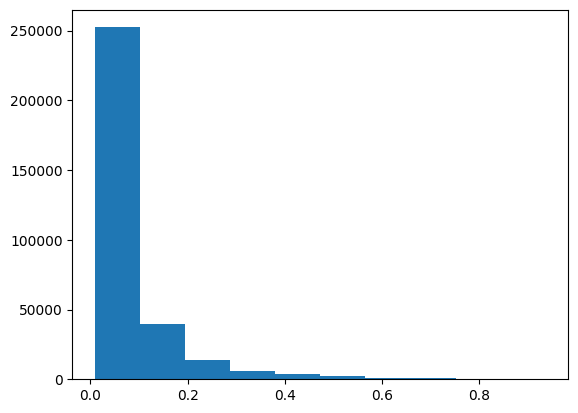

In [ ]:
proba = 1 / (1 + np.exp(- statsLogitModel1.fittedvalues ))
plt.hist(proba)

The confusion matrix shows there is a high false positive and false negative, so the statsmodel1 does not perform well due to the imbalance outcomes in the reposonse variable.  

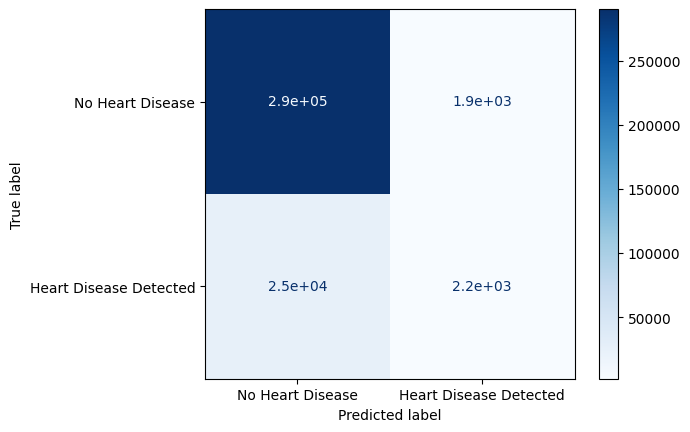

In [ ]:
cm1 = statsLogitModel1.pred_table(threshold=0.5)
confusionMatrixPlot(cm1)

### StatsModel2

Encoded categorical data by one hot encoding technique

In [22]:
onehotencoded_categories = onehot_eoncoder(categorical_data)

The results from statsmodel2 seems not well because all predicted variables are not significant due to p-value is 1, so it may indicate there is a server multicollinearity problem.

In [23]:
statsLogitModel2 = statsLogModel(onehotencoded_categories, response_feature)
statsLogitModel2.summary()

Optimization terminated successfully.
         Current function value: 0.227163
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319761
Method:                           MLE   Df Model:                           33
Date:                Thu, 28 Mar 2024   Pseudo R-squ.:                  0.2226
Time:                        05:00:57   Log-Likelihood:                -72646.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3314   9.13e+04  -3.63e-06      1.000   -1.79e+05    1.79e+05
0             -0.3430   4.53e+05  -7.58e-07      1.000   -8.87e+05    8.87e+05
1              0.0115   4.54e+05   2.54e-08      1.000    -8.9e+05     8.9e+05
2             -0.0431   8.52e+04  -5.06e-07      1.000   -1.67e+05    1.67e+05
3             -0.2883   9.24e+04  -3.12e-06      1.000   -1.81e+05    1.81e+05
4             -0.6878   1.95e+05  -3.54e-06      1.000   -3.81e+05    3.81e+05
5              0.3563   1.91e+05   1.87e-06      1.000   -3.74e+05    3.74e+05
6             -0.2930   3.87e+05  -7.58e-07      1.000   -7.58e+05    7.58e+05
7             -0.0384   3.88e+05   -9.9e-08      1.000   -7.61e+05    7.61e+05
8             -0.5162   3.11e+05  -1.66e-06      1.000    -6.1e+05     6.1e+05
9              0.1848   3.11e+05   5.95e-07      1.000   -6.09e+05    6.09e+05
10            -1.6306      5e+05  -3.26e-06      1.000    -9.8e+05     9.8e+05
11            -1.4816   5.04e+05  -2.94e-06      1.000   -9.88e+05    9.88e+05
12            -1.1142      5e+05  -2.23e-06      1.000    -9.8e+05     9.8e+05
13            -1.0032   5.03e+05  -1.99e-06      1.000   -9.86e+05    9.86e+05
14            -0.6029   5.01e+05   -1.2e-06      1.000   -9.83e+05    9.83e+05
15            -0.2829   5.02e+05  -5.63e-07      1.000   -9.84e+05    9.84e+05
16             0.1204   5.01e+05    2.4e-07      1.000   -9.82e+05    9.82e+05
17             0.3446   5.02e+05   6.87e-07      1.000   -9.84e+05    9.84e+05
18             0.5950   5.01e+05   1.19e-06      1.000   -9.82e+05    9.82e+05
19             0.8240   5.02e+05   1.64e-06      1.000   -9.83e+05    9.83e+05
20             1.0961   5.02e+05   2.18e-06      1.000   -9.84e+05    9.84e+05
21             1.2850      5e+05   2.57e-06      1.000   -9.81e+05    9.81e+05
22             1.5189   5.01e+05   3.03e-06      1.000   -9.81e+05    9.81e+05
23             0.1615   8.47e+04   1.91e-06      1.000   -1.66e+05    1.66e+05
24            -0.3997   8.44e+04  -4.73e-06      1.000   -1.65e+05    1.65e+05
25            -0.1854   8.45e+04  -2.19e-06      1.000   -1.66e+05    1.66e+05
26            -0.1029   8.43e+04  -1.22e-06      1.000   -1.65e+05    1.65e+05
27             0.1093   8.46e+04   1.29e-06      1.000   -1.66e+05    1.66e+05
28             0.0858   8.48e+04   1.01e-06      1.000   -1.66e+05    1.66e+05
29            -0.2774   5.28e+05  -5.26e-07      1.000   -1.03e+06    1.03e+06
30            -0.1256    5.3e+05  -2.37e-07      1.000   -1.04e+06    1.04e+06
31             0.2207   5.31e+05   4.15e-07      1.000   -1.04e+06    1.04e+06
32            -0.1491   5.27e+05  -2.83e-07      1.000   -1.03e+06    1.03e+06
33            -0.1678   5.97e+05  -2.81e-07      1.000   -1.17e+06    1.17e+06
34            -0.1636   5.95e+05  -2.75e-07      1.000   -1.17e+06    1.17e+06
35            -1.0992   3.15e+05  -3.49e-06      1.000   -6.18e+05    6.18e+05
36             0.4858   3.15e+05   1.54e-06      1.000   -6.18e+05    6.18e+05
37

The histogram plot and the confusion matrix in the statsmodel2 has the same problem as the statsmodel1

(array([2.37781e+05, 4.77460e+04, 1.57000e+04, 8.73200e+03, 4.08100e+03,
        2.58900e+03, 1.61400e+03, 9.36000e+02, 4.74000e+02, 1.42000e+02]),
 array([0.00354831, 0.09645871, 0.18936911, 0.28227951, 0.37518992,
        0.46810032, 0.56101072, 0.65392112, 0.74683153, 0.83974193,
        0.93265233]),
 <BarContainer object of 10 artists>)

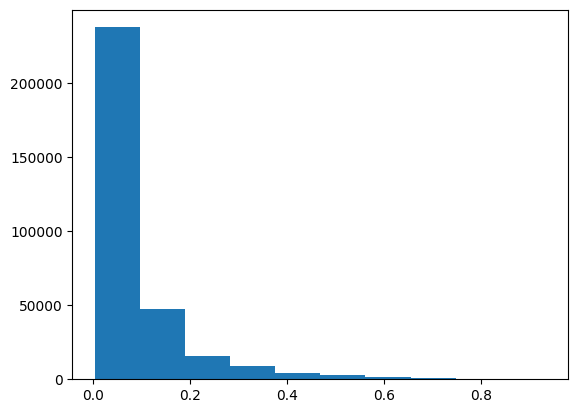

In [ ]:
plt.hist(1 / (1 + np.exp(- statsLogitModel2.fittedvalues )))

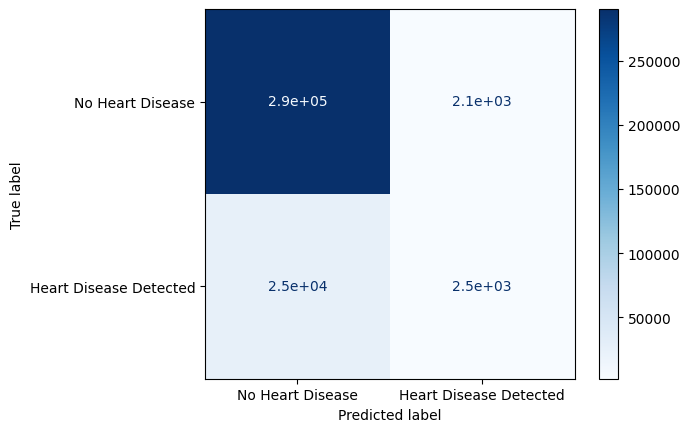

In [ ]:
cm2 = statsLogitModel2.pred_table(threshold=0.5)
confusionMatrixPlot(cm2)

### StatsModel3

Encoded categorical variable by frequency encoding tenchqiue

In [24]:
frequency_encoeded_cate = frequency_encoder(categorical_data, True)

The statsmodel3 is significant because its p-value is 0 and all predictors in the statsmodel3 are significant.

In the statsmodel3, the AlcoholDrinking has a positive coefficient , but a lot of coefficients become negative in this case.

In [ ]:
statsLogitModel3 = statsLogModel(frequency_encoeded_cate, response_feature)
statsLogitModel3.summary()

Optimization terminated successfully.
         Current function value: 0.248685
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319782
Method:                           MLE   Df Model:                           12
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.1490
Time:                        03:17:48   Log-Likelihood:                -79528.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.5608      0.156     61.099      0.000       9.254       9.868
Smoking             -2.8359      0.079    -35.748      0.000      -2.991      -2.680
AlcoholDrinking      0.5460      0.038     14.460      0.000       0.472       0.620
Stroke              -1.4534      0.024    -59.705      0.000      -1.501      -1.406
DiffWalking         -0.9865      0.024    -41.388      0.000      -1.033      -0.940
Sex                -12.3470      0.283    -43.579      0.000     -12.902     -11.792
Race                 0.5892      0.025     23.267      0.000       0.540       0.639
Diabetic            -1.0587      0.021    -50.632      0.000      -1.100      -1.018
PhysicalActivity    -0.3423      0.028    -12.072      0.000      -0.398      -0.287
GenHealth           -2.8959      0.071    -40.857      0.000      -3.035      -2.757
Asthma              -0.1940      0.025     -7.659      0.000      -0.244      -0.144
KidneyDisease       -0.8980      0.026    -34.085      0.000      -0.950      -0.846
SkinCancer          -0.7535      0.023    -32.452      0.000      -0.799      -0.708
====================================================================================
"""

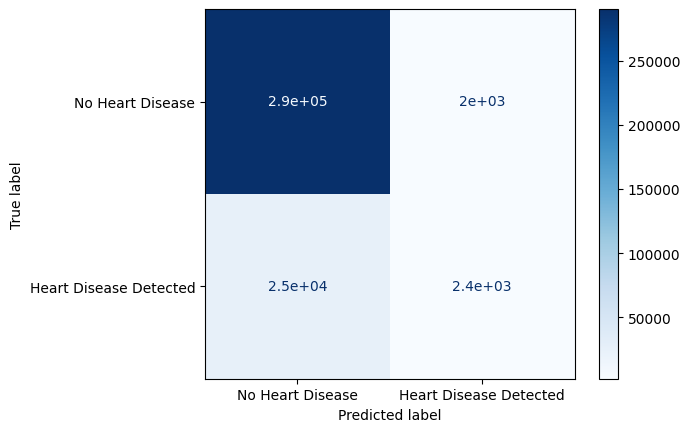

In [ ]:
cm3 = statsLogitModel3.pred_table(threshold=0.5)
confusionMatrixPlot(cm3)

The statsmodel4 is developed by the numerical variables + one hot encoded categorical variables.

The model seems does not perform well becuase of multicollieanrity issue, so if we utilize one hot encoding technique later for models, we should consider remove some columns.

For example, SkinCancer variable has Yes and No values. The one hot encoding produces two dummy variables SkinCancer_Yes and SkinCancer_No. These two columns consists of value 1 and 0. In the SkinCancer_Yes variable, the 1 means that the person has skin cancer and the 0 means that person does not. As a result, SkinCancer_No is a meaningless.

In [ ]:
statsLogitModel4 = statsLogModel(pd.concat([numerical_data,
                                            onehotencoded_categories], axis = 1),
                                 response_feature)
statsLogitModel4.summary()

Optimization terminated successfully.
         Current function value: 0.241903
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319769
Method:                           MLE   Df Model:                           25
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.1722
Time:                        03:17:50   Log-Likelihood:                -77359.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2138        nan        nan        nan         nan         nan
BMI               -0.0093      0.001     -8.713      0.000      -0.011      -0.007
PhysicalHealth     0.0028      0.001      3.226      0.001       0.001       0.004
MentalHealth      -0.0130      0.001    -15.084      0.000      -0.015      -0.011
SleepTime          0.0243      0.004      5.836      0.000       0.016       0.032
0                 -0.3076   9.14e+04  -3.37e-06      1.000   -1.79e+05    1.79e+05
1                  0.0938   9.15e+04   1.02e-06      1.000   -1.79e+05    1.79e+05
2                  0.1086        nan        nan        nan         nan         nan
3                 -0.3224        nan        nan        nan         nan         nan
4                 -0.7237        nan        nan        nan         nan         nan
5                  0.5098        nan        nan        nan         nan         nan
6                 -0.3629        nan        nan        nan         nan         nan
7                  0.1491        nan        nan        nan         nan         nan
8                 -0.4000        nan        nan        nan         nan         nan
9                  0.1861        nan        nan        nan         nan         nan
10                 0.1433   5.13e+04    2.8e-06      1.000   -1.01e+05    1.01e+05
11                -0.4567   5.14e+04  -8.88e-06      1.000   -1.01e+05    1.01e+05
12                -0.0771    5.1e+04  -1.51e-06      1.000   -9.99e+04    9.99e+04
13                -0.2497   5.16e+04  -4.84e-06      1.000   -1.01e+05    1.01e+05
14                 0.0992   5.17e+04   1.92e-06      1.000   -1.01e+05    1.01e+05
15                 0.3272   5.12e+04   6.39e-06      1.000      -1e+05       1e+05
16                -0.2824        nan        nan        nan         nan         nan
17                 0.0786        nan        nan        nan         nan         nan
18                 0.4384        nan        nan        nan         nan         nan
19                -0.4484        nan        nan        nan         nan         nan
20                -0.0656        nan        nan        nan         nan         nan
21                -0.1482        nan        nan        nan         nan         nan
22                -1.2017        nan        nan        nan         nan         nan
23                 0.5587        nan        nan        nan         nan         nan
24                 0.0675        nan        nan        nan         nan         nan
25                 0.9281        nan        nan        nan         nan         nan
26                -0.5665        nan        nan        nan         nan         nan
27                -0.1604   1.13e+05  -1.41e-06      1.000   -2.22e+05    2.22e+05
28                -0.0534   1.14e+05   -4.7e-07      1.000   -2.23e+05    2.23e+05
29                -0.4588        nan        nan        nan         nan         nan
30                 0.2450        nan        nan        nan         nan         nan
31  

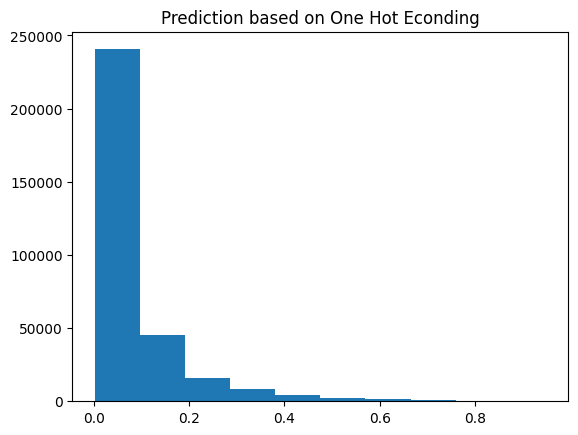

In [ ]:
proba = 1 / (1 + np.exp(- statsLogitModel4.fittedvalues))
plt.hist(proba)
plt.title("Prediction based on One Hot Econding")
plt.show()

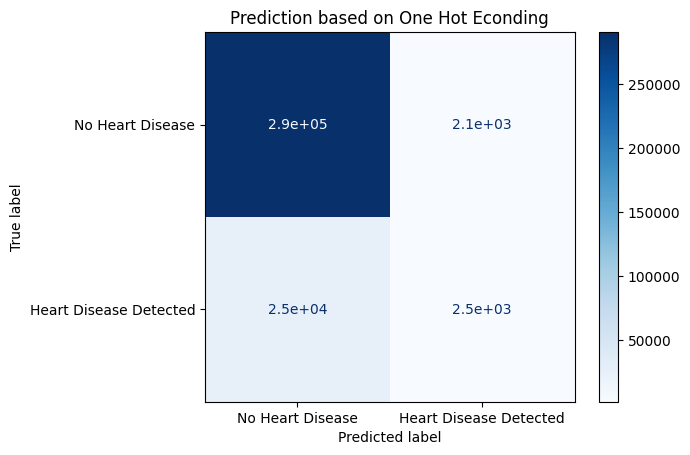

In [ ]:
cm4 = statsLogitModel4.pred_table(threshold=0.5)
confusionMatrixPlot(cm4)
plt.title("Prediction based on One Hot Econding")
plt.show()

The statsmodel5 is developed by the numerical variables + the ordianl encoded categorical variables.

The statsmodel5 perform well becuase it is significant with all the predicted variales, but the AlcoholDrinking and SleepTime has a negative coefficient, so these are unexpected.

In [89]:
statsLogitModel5 = statsLogModel(pd.concat([numerical_data,
                                            ordianlEncoded_categories], axis = 1),
                                 response_feature)
statsLogitModel5.summary()

Optimization terminated successfully.
         Current function value: 0.232864
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319777
Method:                           MLE   Df Model:                           17
Date:                Wed, 27 Mar 2024   Pseudo R-squ.:                  0.2031
Time:                        17:36:45   Log-Likelihood:                -74469.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.9918      0.063    -95.393      0.000      -6.115      -5.869
BMI                  0.0147      0.001     13.073      0.000       0.012       0.017
PhysicalHealth       0.0215      0.001     28.613      0.000       0.020       0.023
MentalHealth         0.0105      0.001     12.039      0.000       0.009       0.012
SleepTime           -0.0337      0.004     -7.734      0.000      -0.042      -0.025
Smoking              0.4380      0.014     31.017      0.000       0.410       0.466
AlcoholDrinking     -0.2589      0.033     -7.787      0.000      -0.324      -0.194
Stroke               1.1528      0.022     51.386      0.000       1.109       1.197
DiffWalking          0.4070      0.018     22.824      0.000       0.372       0.442
Sex                  0.7346      0.014     51.101      0.000       0.706       0.763
AgeCategory          0.2833      0.003     94.557      0.000       0.277       0.289
Race                 0.0331      0.006      5.192      0.000       0.021       0.046
Diabetic             0.2972      0.008     37.154      0.000       0.281       0.313
PhysicalActivity    -0.0905      0.016     -5.697      0.000      -0.122      -0.059
GenHealth           -0.0311      0.005     -6.103      0.000      -0.041      -0.021
Asthma               0.3503      0.019     18.358      0.000       0.313       0.388
KidneyDisease        0.6954      0.024     28.658      0.000       0.648       0.743
SkinCancer           0.1211      0.019      6.289      0.000       0.083       0.159
====================================================================================
"""

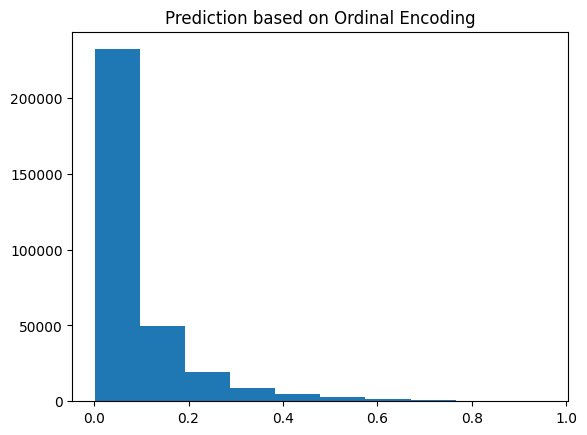

In [90]:
proba = 1 / (1 + np.exp(- statsLogitModel5.fittedvalues))
plt.hist(proba)
plt.title("Prediction based on Ordinal Encoding")
plt.show()

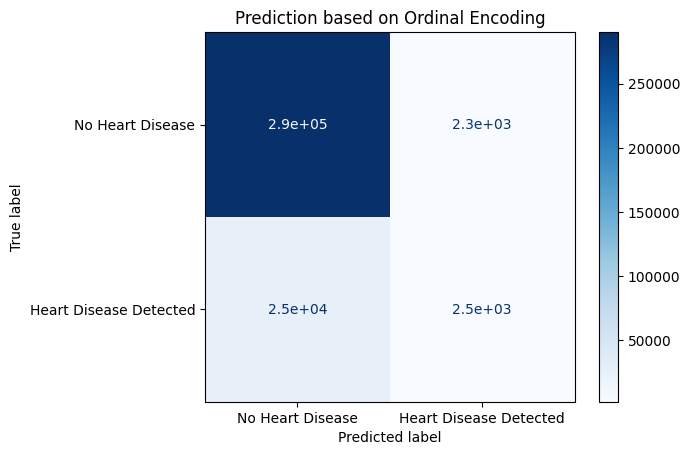

In [91]:
cm5 = statsLogitModel5.pred_table(threshold = 0.5)
confusionMatrixPlot(cm5)
plt.title("Prediction based on Ordinal Encoding")
plt.show()

Author: Arya Patel

# Feature Engineering


Adding three more variables walkingSpeed, meanAge, and BMI_Distiniction to see if we can improve the model.

## Feature Engineering Functions

Define a general walking speed for different people from different age group.

For example, if she is between age 20 and 29, her general walking speed is probably 1.35 Meter/Sec according to https://www.healthline.com/health/exercise-fitness/average-walking-speed#average-speed-by-age

In [ ]:
# Feature Engineering
# defining BMI categories option 2

def calculate_walkingspeed(age):
  if 20<=age<=29:
          return 1.35
          #featured_heartDisease.at[index, "Walking Speed"]=1.35
  elif 30<=age<=39:
          return 1.385
          # featured_heartDisease.at[index, "Walking Speed"]=1.385
  elif 40<=age<=49:
          return 1.41
           # featured_heartDisease.at[index, "Walking Speed"]=1.41
  elif 50<=age<=59:
          return 1.37
           # featured_heartDisease.at[index, "Walking Speed"]=1.37
  elif 60<=age<=69:
          return 1.29
           # featured_heartDisease.at[index, "Walking Speed"]=1.29
  elif 70<=age<=79:
          return 1.195
            #featured_heartDisease.at[index, "Walking Speed"]=1.195
  elif 80<=age<=89:
          return .955
          ## featured_heartDisease.at[index, "Walking Speed"]=.955

## BMI Distinction

Underweight: BMI less than 18.5

Normal weight: BMI 18.5 to 24.9

Overweight: BMI 25 to 29.9

Obesity:

1. Class I (Moderate): BMI 30 to 34.9
2. Class II (Severe): BMI 35 to 39.9
3. Class III (Very severe or morbid obesity): BMI 40 and above


In [ ]:
featured_heartDisease = data.copy()

featured_heartDisease['BMI_Distinction'] = pd.cut(
    featured_heartDisease['BMI'],
    bins= [0,18.5, 24.9, 29.9,34.9,39.9, float('inf')],
    labels=["Underweight", "Normal Weight", "Overweight",
            "Class I Obesity","Class II Obesity", "Class III Obesity"]
    )

## Mean Age

The AgeCategory variable is an object type. The values are string like 20-29, so we splited the string and only convert 20 and 29 to integers then find the mean of 20 and 29 to calculate the meanAge.

In [ ]:
temp_data = data['AgeCategory'].copy()

# featured_heartDisease.loc[featured_heartDisease['AgeCategory'] == '80 or older', 'AgeCategory'] = 80

# The value has "80 or older", so cannot split strings with "-"
  # decided to replace the value with an integer
temp_data[temp_data == '80 or older'] = 80

split_val= temp_data.astype(str).str.split('-', expand=True)

convert_ind0 = split_val[0].astype(float)
convert_ind2 = split_val[1].astype(float)
convert_ind2 = convert_ind2.fillna(80)

mean_val= (convert_ind0 + convert_ind2)/2
featured_heartDisease['MeanAge']= mean_val

In [ ]:
featured_heartDisease.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI_Distinction,MeanAge
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,Underweight,57.0
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,Normal Weight,80.0
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,Overweight,67.0
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,Normal Weight,77.0
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,Normal Weight,42.0


## Walking Speed

In [ ]:
#does same thing
#defining walking speeds
#iterate through dataFrame and set Walking Speeds based on age range
#dataset has difference in walking speed so  this is from the average walking speed by age link

featured_heartDisease['Walking_Speed'] = featured_heartDisease['MeanAge'].apply(calculate_walkingspeed)

In [ ]:
featured_heartDisease.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI_Distinction,MeanAge,Walking_Speed
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,...,Yes,Yes,Very good,5.0,Yes,No,Yes,Underweight,57.0,1.370
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,...,No,Yes,Very good,7.0,No,No,No,Normal Weight,80.0,0.955
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,...,Yes,Yes,Fair,8.0,Yes,No,No,Overweight,67.0,1.290
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,...,No,No,Good,6.0,No,No,Yes,Normal Weight,77.0,1.195
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,...,No,Yes,Very good,8.0,No,No,No,Normal Weight,42.0,1.410


Author: Junze He

In [ ]:
featured_heartDisease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   HeartDisease      319795 non-null  object  
 1   BMI               319795 non-null  float64 
 2   Smoking           319795 non-null  object  
 3   AlcoholDrinking   319795 non-null  object  
 4   Stroke            319795 non-null  object  
 5   PhysicalHealth    319795 non-null  float64 
 6   MentalHealth      319795 non-null  float64 
 7   DiffWalking       319795 non-null  object  
 8   Sex               319795 non-null  object  
 9   AgeCategory       319795 non-null  object  
 10  Race              319795 non-null  object  
 11  Diabetic          319795 non-null  object  
 12  PhysicalActivity  319795 non-null  object  
 13  GenHealth         319795 non-null  object  
 14  SleepTime         319795 non-null  float64 
 15  Asthma            319795 non-null  object  
 16  Ki

In [ ]:
new_numerical_features, new_categorical_fetaures = split_types(featured_heartDisease)

y = new_categorical_fetaures.HeartDisease
new_categorical_fetaures = new_categorical_fetaures.drop("HeartDisease", axis=1)

In [ ]:
new_ordianl_encoded_cateFeatures = ordinal_catfeatures_encoder(new_categorical_fetaures)
encoded_featured_heartDisease = pd.concat([new_numerical_features, new_ordianl_encoded_cateFeatures], axis=1)

Encoded categorical variables by ordianl encoding technique and add new variables into the dataset.

From the heatmap, we can see there is no significant correlation in the dataset with adding three more new variables.

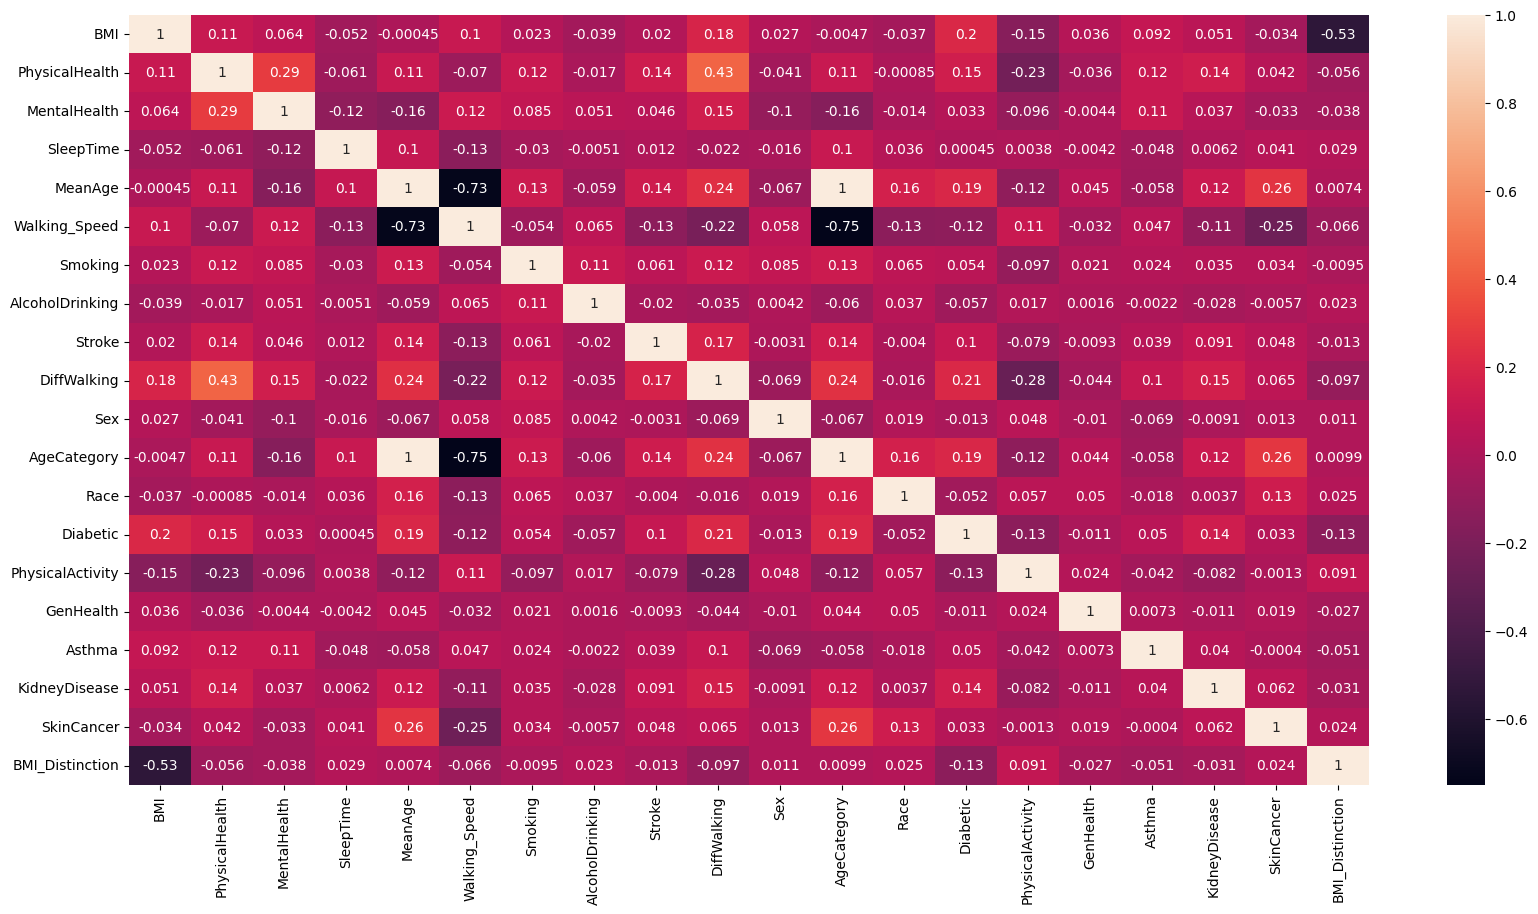

In [ ]:
correlation = encoded_featured_heartDisease.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True)
plt.show()

Author: Junze He and Giovanni Cinque

## Data Preprocessing

In [ ]:
# No missing values (no check)

#For checking for missing values (there are none as the non-null count is the same through all categories).
heartDisease = data.copy()
heartDisease.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
response_feature = heartDisease["HeartDisease"]
response_feature.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [ ]:
# split categorical features and numerical features into different variables
numerical_data, categorical_data = split_types(heartDisease)
categorical_data = categorical_data.drop("HeartDisease", axis = 1)

In [ ]:
response_feature.head()

0    No
1    No
2    No
3    No
4    No
Name: HeartDisease, dtype: object

In [ ]:
# sns.heatmap(numerical_data)
numerical_data.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime
0,16.60,3.0,30.0,5.0
1,20.34,0.0,0.0,7.0
2,26.58,20.0,30.0,8.0
3,24.21,0.0,0.0,6.0
4,23.71,28.0,0.0,8.0


In [ ]:
categorical_data.head()

,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,Yes,No,Yes
1,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,No,No,No
2,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,Yes,No,No
3,No,No,No,No,Female,75-79,White,No,No,Good,No,No,Yes
4,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,No,No,No


In [ ]:
categorical_data.nunique()

Smoking              2
AlcoholDrinking      2
Stroke               2
DiffWalking          2
Sex                  2
AgeCategory         13
Race                 6
Diabetic             4
PhysicalActivity     2
GenHealth            5
Asthma               2
KidneyDisease        2
SkinCancer           2
dtype: int64

<Axes: >

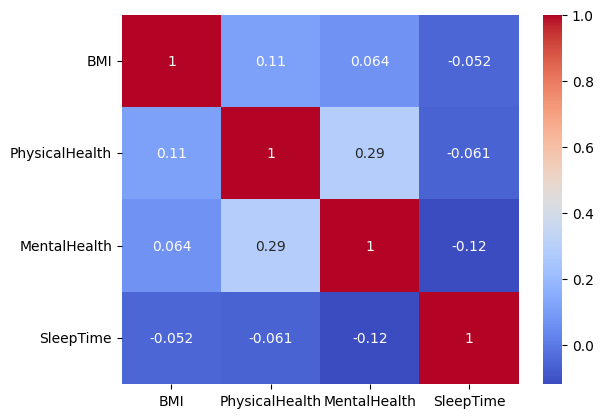

In [ ]:
#heatmap checking for collinearity of numerical dadta
sns.heatmap(numerical_data.corr(), cmap='coolwarm', annot=True)

In [ ]:
# encode categorical features
# categorical_data_encoded = frequency_encoder(categorical_data)

# categorical_data_encoded = onehot_eoncoder(categorical_data)

categorical_data_encoded = ordinal_catfeatures_encoder(categorical_data)

In [ ]:
#encode response feature
response_feature_encoded = response_feature.map({"Yes": 1, "No": 0})

In [ ]:
# concat numerical and categorical data
predicted_variables = pd.concat([numerical_data,
                                         categorical_data_encoded], axis=1)
predicted_variables.columns = predicted_variables.columns.astype(str)

In [ ]:
predicted_variables_ros, response_feature_encoded_ros = oversampling(predicted_variables, response_feature_encoded)

In [ ]:
# Split
train_x, test_x, train_y, test_y = train_test_split(predicted_variables_ros,
                                                    response_feature_encoded_ros, test_size=0.2, shuffle=True)

In [ ]:
# Scale
train_scaled_x = scale(train_x)
test_scaled_x = scale(test_x)

In [ ]:
# Oversampling for train
# train_x_scaled_ros, train_y_ros = oversampling(train_scaled_x, train_y)
# train_y_ros.value_counts()
print(train_y.value_counts())
test_y.value_counts()

0    233952
1    233923
Name: HeartDisease, dtype: int64


1    58499
0    58470
Name: HeartDisease, dtype: int64

In [ ]:
#random under sampling
predicted_variables_rus, response_feature_encoded_rus = undersampling(predicted_variables, response_feature_encoded)

In [ ]:
#Split
train_x_rus, test_x_rus, train_y_rus, test_y_rus = train_test_split(predicted_variables_rus, response_feature_encoded_rus, test_size=0.2, shuffle=True)

In [ ]:
# Scale
train_scaled_x_rus = scale(train_x_rus)
test_scaled_x_rus = scale(test_x_rus)

In [ ]:
print(train_y_rus.value_counts())
test_y_rus.value_counts()

Author: Junze He

## Model

In [ ]:
# XGBClassifier
classifier = XGBClassifier(n_estimators=100, learning_rate=0.05)
classifier.fit(
    train_scaled_x, train_y,
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
predictions = classifier.predict(test_scaled_x)

In [ ]:
accuracy = accuracy_score(predictions, test_y)
accuracy

0.6952953346613205

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
validation_score = cross_val_score(classifier, train_scaled_x, train_y, cv=cv)

Shuffled Validation Mean Accuracy: 77.12%
              precision    recall  f1-score   support

           0       0.63      0.73      0.67     50487
           1       0.76      0.67      0.71     66482

    accuracy                           0.70    116969
   macro avg       0.70      0.70      0.69    116969
weighted avg       0.70      0.70      0.70    116969



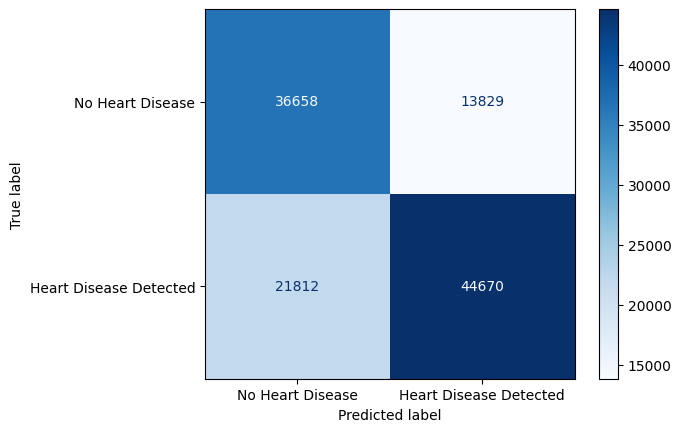

In [ ]:
cm = confusion_matrix(predictions, test_y)
cm_dis = ConfusionMatrixDisplay(cm, display_labels=['No Heart Disease',
                                                        "Heart Disease Detected"])
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(validation_score.mean()*100))
print(cm_dis.plot(cmap=plt.cm.Blues))
print(classification_report(predictions, test_y))

Author: Giovanni Cinque

In [ ]:
#XGB Classifier undersampling
classifier_rus = XGBClassifier(n_estimators=100, learning_rate=0.05)
classifier_rus.fit(
    train_scaled_x_rus, train_y_rus,
    verbose=False
)

In [ ]:
predictions_rus = classifier_rus.predict(test_scaled_x_rus)

In [ ]:
accuracy_rus = accuracy_score(predictions_rus, test_y_rus)
accuracy_rus

In [ ]:
cv_rus = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
validation_score_rus = cross_val_score(classifier_rus, train_scaled_x_rus, train_y_rus, cv=cv_rus)

In [ ]:
cm_rus = confusion_matrix(predictions_rus, test_y_rus)
cm_dis_rus = ConfusionMatrixDisplay(cm_rus, display_labels=['No Heart Disease',
                                                        "Heart Disease Detected"])

In [ ]:
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(validation_score_rus.mean()*100))
print(cm_dis_rus.plot(cmap=plt.cm.Blues))
print(classification_report(predictions_rus, test_y_rus))

Author: Junze He

### Pipeline

In [ ]:
def pipelineModel(model, x_ros, y_ros, ordinalEncoder=True):
  cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
  train_x, test_x, train_y, test_y = train_test_split(
      x_ros,
      y_ros,
      test_size=0.2,
      shuffle=True
      )

  numerical_transformer = SimpleImputer(strategy="median")

  categorical_transformer = Pipeline(
      steps=[
      ("Imputer", SimpleImputer(strategy="most_frequent")),
      ("ordinal", OrdinalEncoder())
      ]
  )

  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numerical_transformer, numerical_cols),
          ("cat", categorical_transformer, categorical_cols),
      ]
  )

  my_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
         ('scaler', StandardScaler()),
        ("model", model)
    ]
  )

  my_pipeline.fit(train_x, train_y)

  predictions = my_pipeline.predict(test_x)
  cm = confusion_matrix(predictions, test_y)
  report = classification_report(predictions, test_y)

  validation_score = cross_val_score(my_pipeline, train_x, train_y, cv=cv)

  return my_pipeline, cm, report, validation_score



In [ ]:
def splitCols(data):
  numerical_cols = [i for i in x.columns if x[i].dtype in ["int64", "float64"]]
  categorical_cols = [i for i in x.columns if x[i].dtype == "object"]
  return numerical_cols, categorical_cols

In [ ]:
# def cross_validation(model, x, y):
#   cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
#   validation= cross_val_score(model, x, y, cv = cv)
#   return validation

In [ ]:
y = heartDisease.copy().HeartDisease
x = heartDisease.copy().drop("HeartDisease", axis=1)

In [ ]:
numerical_cols, categorical_cols = splitCols(x)
y = y.map({"No": 0, "Yes":1})
x_ros, y_ros = oversampling(x, y)

In [ ]:
# RandomForestClassifier
# n_estimator: how many trees in the model which has a series of decision trees
rfc_model = RandomForestClassifier(n_estimators=35)
rfc_pipeline, rfc_cm, rfc_report, rfc_validation_score = pipelineModel(rfc_model, x_ros, y_ros)

Shuffled Validation Mean Accuracy: 95.90%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     54884
           1       1.00      0.94      0.97     62085

    accuracy                           0.97    116969
   macro avg       0.97      0.97      0.97    116969
weighted avg       0.97      0.97      0.97    116969



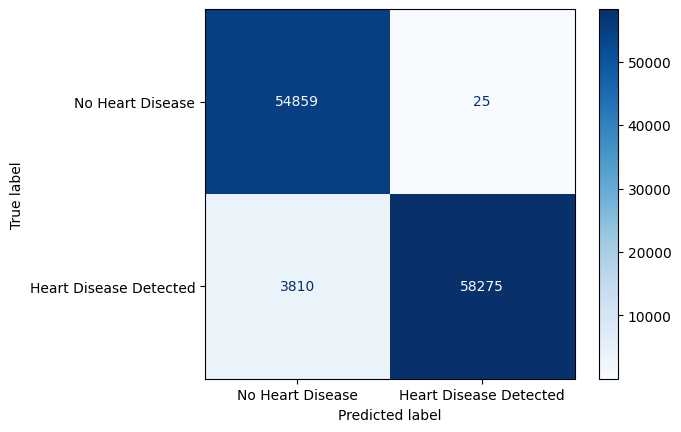

In [ ]:
confusionMatrixPlot(rfc_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(rfc_validation_score.mean()*100))
print(rfc_report)

Author: Jun Ryu

In [ ]:
# DecisionTrees with a tree
# max_depth: the depth of a tree
model_dt = DecisionTreeClassifier(max_depth=35, random_state=1234)
dt_pipeline, dt_cm, dt_report, dt_validation_score = pipelineModel(model_dt, x_ros, y_ros)

Shuffled Validation Mean Accuracy: 96.02%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     54467
           1       1.00      0.94      0.97     62502

    accuracy                           0.97    116969
   macro avg       0.97      0.97      0.97    116969
weighted avg       0.97      0.97      0.97    116969



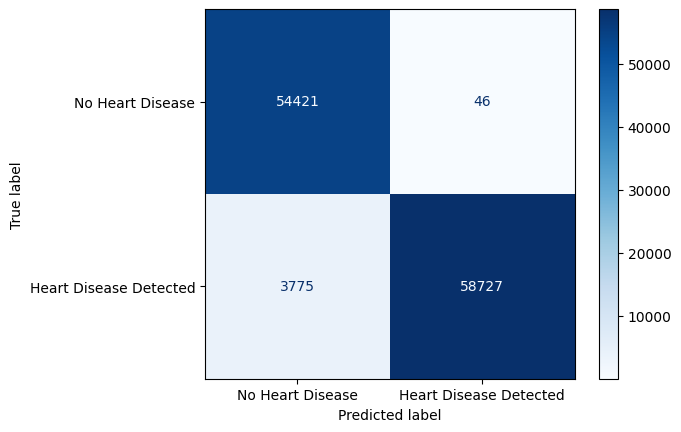

In [ ]:
confusionMatrixPlot(dt_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(dt_validation_score.mean()*100))
print(dt_report)

In [ ]:
# Logistic Regression
model_lr = LogisticRegression(C=0.5, random_state=1234)
lr_pipeline, lr_cm, lr_report, lr_validation_score = pipelineModel(model_lr, x_ros, y_ros)

Shuffled Validation Mean Accuracy: 75.11%
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     56864
           1       0.77      0.75      0.76     60105

    accuracy                           0.75    116969
   macro avg       0.75      0.75      0.75    116969
weighted avg       0.75      0.75      0.75    116969



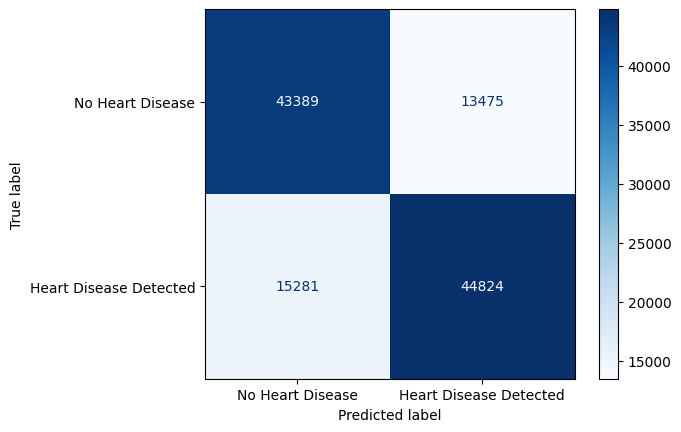

In [ ]:
confusionMatrixPlot(lr_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(lr_validation_score.mean()*100))
print(lr_report)

Author: Junze He

### Model with added more features

In [ ]:
x_added_features = featured_heartDisease.drop('HeartDisease', axis=1).copy()
x_added_features_ros, y_added_features_ros = oversampling(x_added_features, y)
y_added_features_ros.value_counts()

0    292422
1    292422
Name: HeartDisease, dtype: int64

In [ ]:
x_added_features_ros.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI_Distinction,MeanAge,Walking_Speed
0,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,Underweight,57.0,1.370
1,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,Normal Weight,80.0,0.955
2,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,Overweight,67.0,1.290
3,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,Normal Weight,77.0,1.195
4,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,Normal Weight,42.0,1.410


In [ ]:
added_features_rfc_pipeline, added_features_rfc_cm, added_features_rfc_report, added_features_rfc_validation_score = pipelineModel(
    RandomForestClassifier(n_estimators=30),
    x_added_features_ros,
    y_added_features_ros
)

Shuffled Validation Mean Accuracy: 96.09%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     54912
           1       1.00      0.94      0.97     62057

    accuracy                           0.97    116969
   macro avg       0.97      0.97      0.97    116969
weighted avg       0.97      0.97      0.97    116969



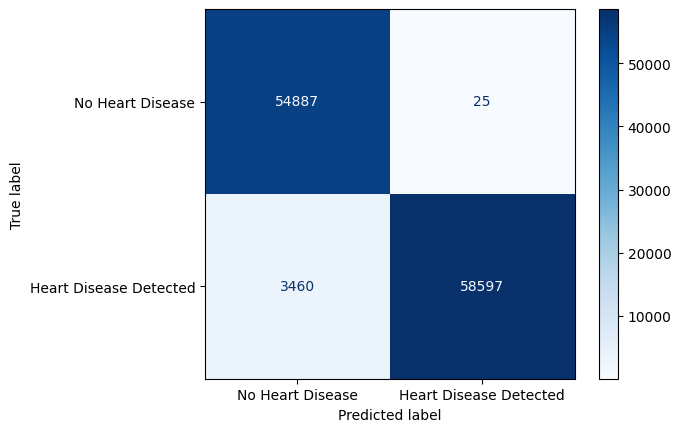

In [ ]:
confusionMatrixPlot(added_features_rfc_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(added_features_rfc_validation_score.mean()*100))
print(added_features_rfc_report)